In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import pdb
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from patch_geo_func import x_ep, y_ep
from sys import stdout
import warnings
np.seterr(invalid = 'raise', under = 'ignore', over = 'ignore')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [4]:
from assign_attr import *
from repel_system import *

In [16]:
LR_Pi_file = 'cortex_94-Ny/Ny-2-LR_Pi.bin'
#pos_file = 'server_data/test_3d_pos.bin'
#pos_file = 'server_data/test_low_3d_pos.bin'
#LR_Pi_file = 'Ny-2-LR_Pi.bin'
#pos_file = 'sobol_test_low_3d_pos.bin'
pos_file = 'uniform_pos_file.bin'
OR_file = 'ORcolor.bin'
vpos_file = 'vpos.bin'
nblock = 32 #5209 #32
blockSize = 1024

a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
ecc = 2.0 # must consistent with the corresponding variables in parameter.m and macro.ipynb
p0 = -np.pi/2
p1 = np.pi/2

grid = np.array([64,104])*2
nx = grid[0]
ny = grid[1]
W = x_ep(ecc,0,k,a,b)
d = (1+2/nx)*W/nx
x = np.linspace(-W/nx, W+W/nx, nx)
W = W+2*W/nx
H = d*ny
y = np.linspace(-H/2, H/2, ny)
mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, pos_file, OR_file, a, b, k, ecc, p0, p1, vpos_file)

x range:[-0.019, 14.508] mm
y range:[-11.170, 11.169] mm
211x342, ecc-polar grid houses 32768 neurons
require 0.086 GB
vpos_x:[-0.018, 14.507]
vpos_y:[-11.169, 11.165]


In [17]:
fig = plt.figure('macroMap',dpi=1000)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, projection='polar')
#mMap.assign_pos_OD0()
#mMap.assign_pos_OD1()
mMap.pODready = False
mMap.pVFready = False
mMap.plot_map(ax1, ax2, pltOD = True, pltVF = True, pltOR = True)
ax1.set_aspect('equal')
ax2.set_thetamin(p0/np.pi*180)
ax2.set_thetamax(p1/np.pi*180)
ax2.set_rmax(2.0)
ax2.set_rmin(0.0)
ax2.grid(False)
ax2.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)
#ax1.set_yticks([0,0.5,1.00,1.50,2.00])

fig.savefig('sobol_test_low_density_uniform.png', dpi = 2000)

assgining visual field: 0.555%

AssertionError: 

In [18]:
# spread uniformly
fig = plt.figure('pos', dpi = 1000)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(121)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
ax2.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax2.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax2.set_aspect('equal')
dt = np.power(2.0,-np.arange(5,10)).reshape(10-5,1)
dt = np.tile(dt,(1,10)).flatten()
oldpos, cL, cR, nL, nR = mMap.make_pos_uniform(dt, seed = 17482321, ax1 = ax1, ax2 = ax2)
fig.savefig('sobol_test_low_density2.png', dpi = 2000)
mMap.save_pos('restructured_pos_file.bin')

smooth area: 108.02521881659332, 108.6865707133522
grid area: 107.99175513432431, 108.4736818958014, used in simulation
0.41584132611751556
no sample points selected
characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.087
particle:
a = 0.10484915973678889
b = 0.10484915973678889
k1 = 2
k2 = 1
cl = 0.08737429978065742
boundary:
a = 0.052424579868394446
b = 0.052424579868394446
k1 = 2
k2 = 1
cl = 0.04368714989032871
2278 boundary points and 16334 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (0.754,0.756)
    radius of influence of particle (1.508,1.513)
    radius of influence of boundary (0.754,0.756)
    default limiting of displacement in one dt: (0.452, 0.454)
initialized
100.000%, 0 particles' displacement are limited, 0 particles freezed



ValueError: too many values to unpack (expected 3)

In [ ]:
fig = plt.figure('convergence', dpi = 150)
ax1 = fig.add_subplot(121)
plt.errorbar(dt[1:], cL[1:,0], yerr = cL[1:,1], c='b', ls ='-', marker = '*')
plt.errorbar(dt[1:], cR[1:,0], yerr = cR[1:,1], c='r', ls ='-', marker = '*')
#ax3.set_ylim(-1,1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2 = fig.add_subplot(122)
ax2.plot(dt[1:], nlimL[1:], '*')
ax2.plot(dt[1:], nlimR[1:], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [ ]:
# spread for VF
fig = plt.figure('vposL', dpi = 600)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(111)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal') 
#dt = np.tile(dt,(nlayer,1)) * np.power(2.0, np.arange(nlayer)).reshape(nlayer,1)
#print(dt)
#dt = None
#vpos, cL, cR, nL, nR = mMap.spread_pos(dt, 10, seed = 17482321, ax1 = ax1, ax2 = ax2)
#del(vpos)
#del(vel)
#if 'vel' in locals():
#   assert('vpos' in locals())
#   vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer, layer_seq, pos = vpos, initial_v = vel, seed = 17482321, ax1 = ax1, ret_vel = True)
#else:
#layer_seq = np.arange(1)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq, pos = vpos, intial_v = vel, seed = 17482321, ax1 = ax1, useOldLayer = True)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq = layer_seq, pos = vpos, intial_v = vel, seed = 17482321, ax1 = ax1, ret_vel = True, useOldLayer = True)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq = layer_seq, seed = 17482321, ax1 = ax1, ret_vel = True, useOldLayer = False)
dt = np.power(2.0,-np.arange(5,6)).reshape(6-5,1)
dt = np.tile(dt,(1,100)).flatten()
#firstTime = False
#if firstTime is True:
#    L = mMap.LR.copy()
#    L[L > 0] = 0
#    L[L < 0] = 1
#    vposL = mMap.pos[:, mMap.ODlabel<0].copy()
#else:
with open('vposL.bin','rb') as f:
    vposL = np.fromfile(f).reshape(2, np.sum(mMap.ODlabel<0))
with open('L.bin','rb') as f:
    L = np.fromfile(f).reshape(mMap.Pi.shape)
    print(np.sum(L>0))
#spreaded = False
#while spreaded is False:
vposL, L, spreaded = mMap.spread_vpos(dt, vposL, L, seed = 17482321, ax = ax1)
print(np.sum(L>0))
with open('vposL.bin','wb') as f:
    vposL.tofile(f)
with open('L.bin','wb') as f:
    L.tofile(f)
fig.savefig('spread_VF_L.png', dpi = 2000)

16170
spread finished
characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.124
particle:
a = 0.1484444400530503
b = 0.1484444400530503
k1 = 2
k2 = 1
cl = 0.1484444400530503
boundary:
a = 0.09896296003536688
b = 0.09896296003536688
k1 = 2
k2 = 1
cl = 0.04948148001768344
640 boundary points and 16334 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (1.068,1.071)
    radius of influence of particle (2.562,2.570)
    radius of influence of boundary (0.854,0.857)
    default limiting of displacement in one dt: (0.641, 0.642)
initialized
78.000%, 0 particles' displacement are limited, 0 particles freezed

NameError: name 'mMap' is not defined

In [ ]:
fig = plt.figure('vposR', dpi = 600)
ax1 = fig.add_subplot(111)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
dt = np.power(2.0,-np.arange(5,8)).reshape(8-5,1)
dt = np.tile(dt,(1,10)).flatten()
firstTime = True
if firstTime is True:
    R = mMap.LR.copy()
    R[R < 0] = 0
    R[R > 0] = 1
    vposR = mMap.pos[:, mMap.ODlabel>0].copy()
else:
    with open('vposR.bin') as f:
        vposR = np.fromfile(f)
    with open('R.bin') as f:
        R = np.fromfile(f, dtype=int)
        print(R)
spreaded = False
while spreaded is False:
    vposR, R, spreaded = mMap.spread_vpos(dt, vposR, R, seed = 17482321, ax = ax1)
    with open('vposR.bin') as f:
        vposR.tofile(f)
    with open('R.bin') as f:
        R.tofile(f)
fig.savefig('spread_VF_R.png', dpi = 2000)

In [ ]:
vpos = np.empty((2,self.nn))
vpos[:, mMap.ODlabel > 0] = vposR
vpos[:, mMap.ODlabel < 0] = vposL
with open('vpos.bin') as f:
    vpos.tofile(f)

characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.097
particle:
a = 0.1169237370667417
b = 0.1169237370667417
k1 = 2
k2 = 1
cl = 0.1169237370667417
boundary:
a = 0.07794915804449448
b = 0.07794915804449448
k1 = 2
k2 = 1
cl = 0.03897457902224724
2278 boundary points and 16334 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (0.841,0.843)
    radius of influence of particle (2.018,2.024)
    radius of influence of boundary (0.673,0.675)
    default limiting of displacement in one dt: (0.505, 0.506)
initialized
100.000%, 0 particles' displacement are limited, 0 particles freezedd

characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.097
particle:
a = 0.1169237370667417
b = 0.1169237370667417
k1 = 2
k2 = 1
cl = 0.1169237370667417
boundary:
a = 0.07794915804449448
b = 0.07794915804449448
k1 = 2
k2 = 1
cl = 0.03897457902224724
2278 boundary points and 16334 particles initialized
in units of grids

NameError: name 'vpos' is not defined

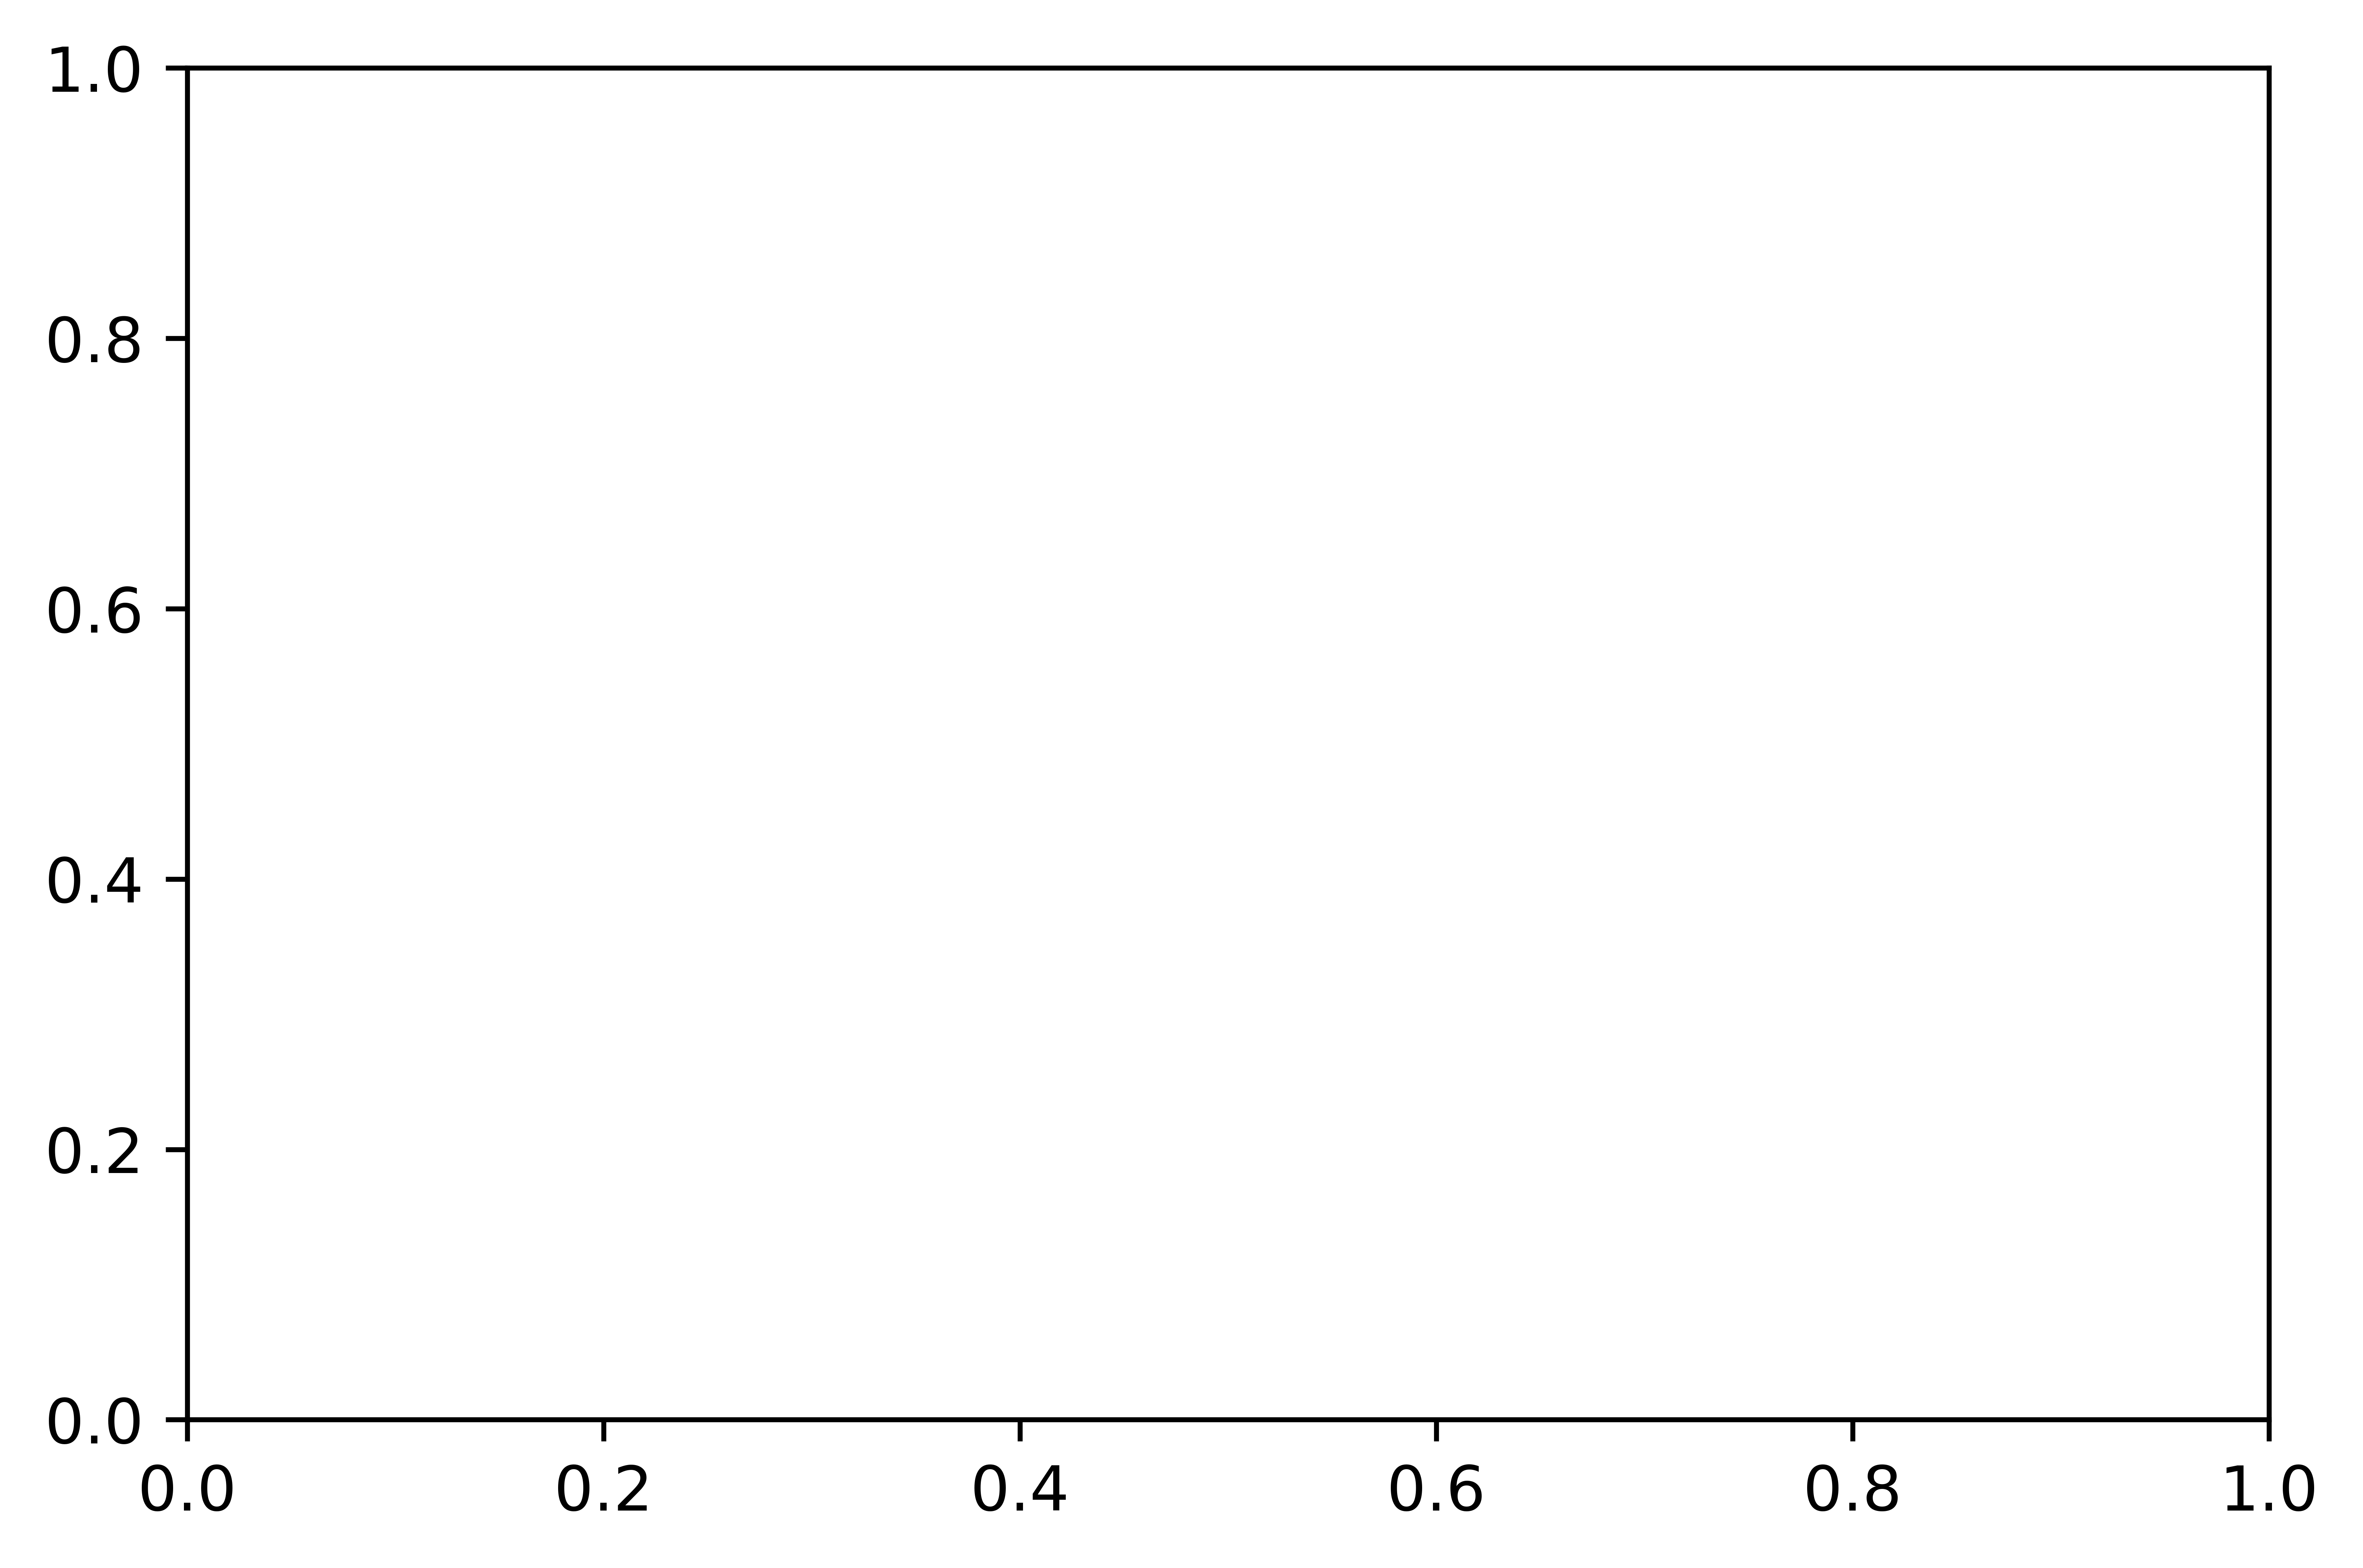

In [5]:
fig = plt.figure('endpoint', dpi = 600)
ax1 = fig.add_subplot(121)
ax1.plot(vposL[0,:], vposL[1,:], ',k')
ax2 = fig.add_subplot(122)
ax2.plot(vposR[0,:], vposR[1,:], ',k')
fig.savefig('spreaded.png', dpi = 2000)

In [11]:
%debug

> /home/wd554/local/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/twodim_base.py(95)fliplr()
     93     m = asanyarray(m)
     94     if m.ndim < 2:
---> 95         raise ValueError("Input must be >= 2-d.")
     96     return m[:, ::-1]
     97 



ipdb>  up


> /scratch/wd554/patchV1/repel_system.py(56)initialize()
     54 
     55             print('\n')
---> 56             dis_range = np.fliplr(np.linspace(np.min(dis), np.max(dis), self.nlayer+1))
     57             for i in range(self.nlayer):
     58                 if i == self.nlayer-1:



ipdb>  dis.shape


(16334,)


ipdb>  self.nlayer


10


ipdb>  np.min(dis), np.max(dis)


(0.053565381399810263, 6.781148748371172)


ipdb>  np.linspace(np.min(dis), np.max(dis), self.nlayer+1)


array([0.05356538, 0.72632372, 1.39908205, 2.07184039, 2.74459873,
       3.41735706, 4.0901154 , 4.76287374, 5.43563207, 6.10839041,
       6.78114875])


ipdb>  q


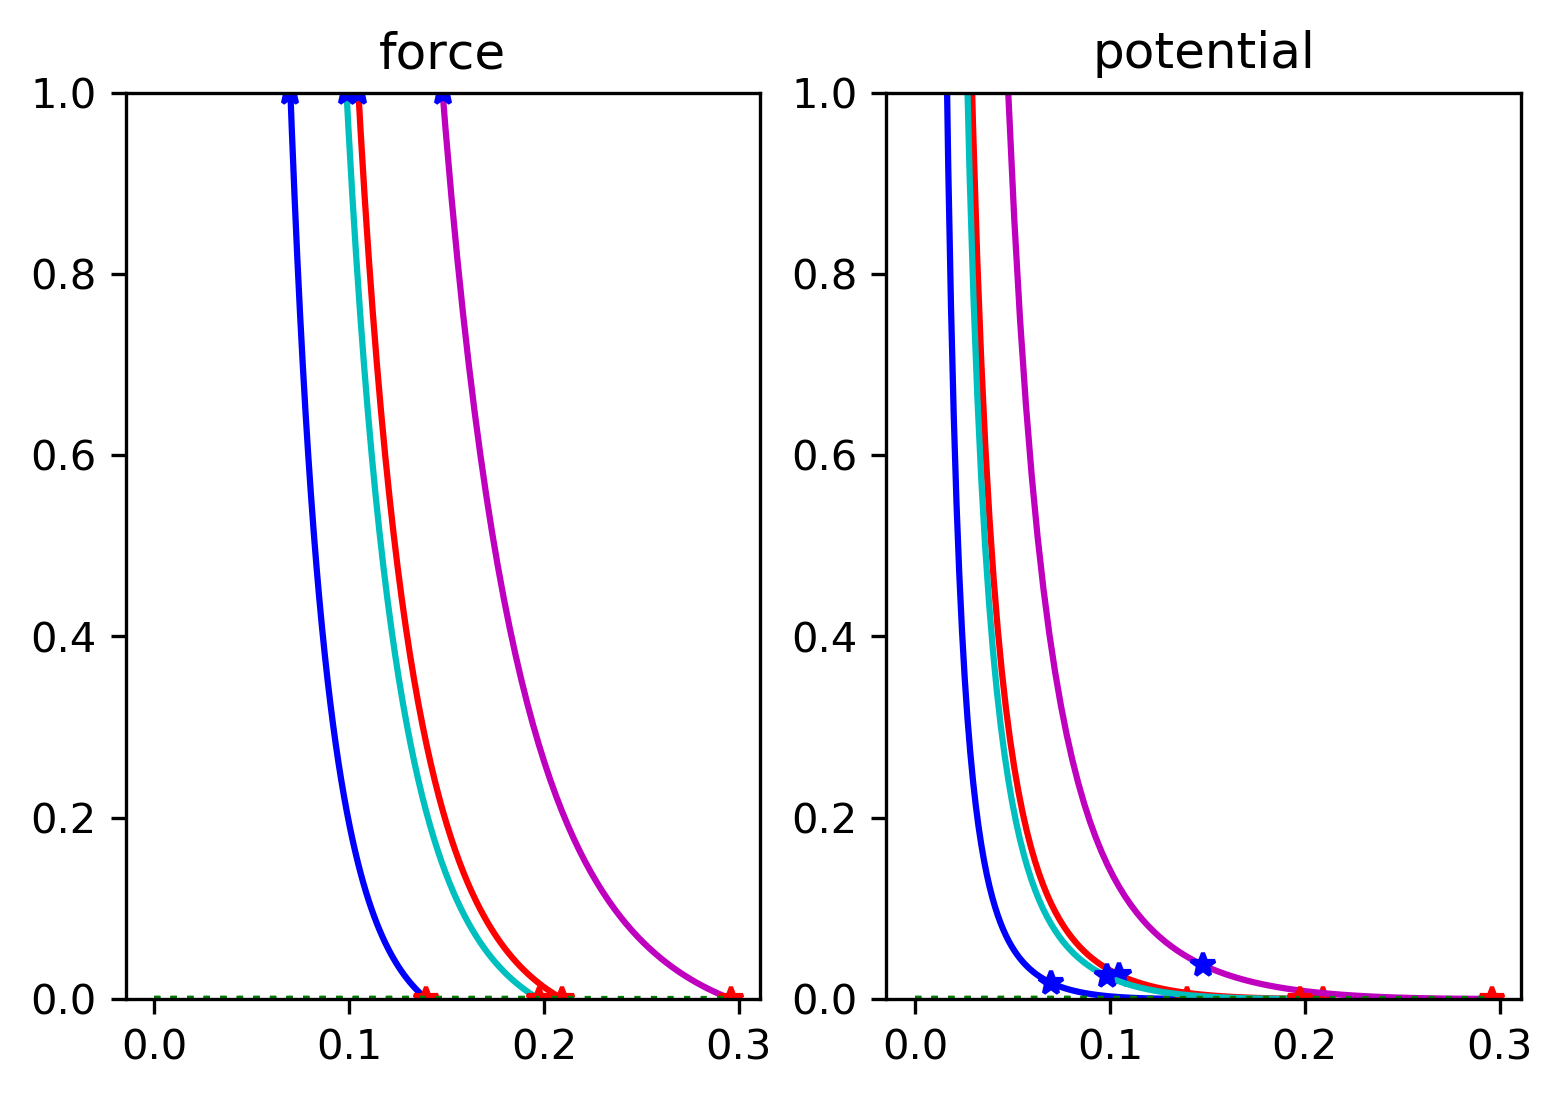

In [14]:
unit_hexagon_area = 6*np.sqrt(3)/4
area = mMap.subgrid[0] * mMap.subgrid[1] * np.sum(mMap.LR == 1)
cl = np.sqrt(3*(area/np.sum(mMap.ODlabel>0))/unit_hexagon_area)
p_scale = 1.2 # potential extension
b_scale = 0.8 # potential extension
pk1, pk2 = 2, 1
bk1, bk2 = 2, 1
a_particle = cl*p_scale
a_boundary = cl*b_scale
epsilon = 0.01
n = 100
top = 1
bottom = 0
fig = plt.figure('potential-force', dpi = 150)
ax1 = fig.add_subplot(121)
ax1.set_ylim(bottom, top)
ax2 = fig.add_subplot(122)
ax2.set_ylim(bottom, top)
potential = L_J_potiential(a_particle,a_particle,pk1,pk2,cl*p_scale)
potential.plot(ax1,ax2,'r')
#boundary:
potential = L_J_potiential(a_boundary,a_boundary,bk1,bk2,cl*b_scale)
potential.plot(ax1,ax2,'b')

area = mMap.subgrid[0] * mMap.subgrid[1] * np.sum(mMap.Pi > 0)
cl = np.sqrt(3*(area/np.sum(mMap.ODlabel>0))/unit_hexagon_area)
p_scale = 1.2 # potential extension
b_scale = 0.8 # potential extension
a_particle = cl*p_scale
a_boundary = cl*b_scale
potential = L_J_potiential(a_particle,a_particle,pk1,pk2,cl*p_scale)
potential.plot(ax1,ax2,'m')
#boundary:
potential = L_J_potiential(a_boundary,a_boundary,bk1,bk2,cl*b_scale)
potential.plot(ax1,ax2,'c')